In [1]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
from sagemaker import get_execution_role

In [3]:
aws_role = get_execution_role()


sm_role = sagemaker.get_execution_role()

aws_region = boto3.Session().region_name
sm_session = sagemaker.Session()
sm_client = boto3.client('sagemaker')

print(f"Using Role: {sm_role}")
s3_bucket = sm_session.default_bucket()
s3_bucket

Using Role: arn:aws:iam::287758680514:role/service-role/AmazonSageMaker-ExecutionRole-20231027T004238


'sagemaker-us-east-1-287758680514'

In [4]:
# retrieve data
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{aws_region}",
    "datasets/tabular/uci_abalone/train_csv/abalone_dataset1_train.csv",
    "abalone_dataset1_train.csv",
)

In [6]:
# upload data to S3
!aws s3 cp abalone_dataset1_train.csv s3://{s3_bucket}/xgboost-regression/train.csv

upload: ./abalone_dataset1_train.csv to s3://sagemaker-us-east-1-287758680514/xgboost-regression/train.csv


## convert csv to recordio

In [5]:
import pandas as pd
import io
import numpy as np
import sagemaker.amazon.common as smac

train_set = pd.read_csv('./abalone_dataset1_train.csv', names=[
        "age",
        "sex",
        "Length",
        "Diameter",
        "Height",
        "Whole.weight",
        "Shucked.weight",
        "Viscera.weight",
        "Shell.weight",
    ])

# vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
# labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1.0, 0.0).astype("float32")

# buf = io.BytesIO()
# smac.write_numpy_to_dense_tensor(buf, vectors, labels)
# buf.seek(0)

In [50]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2923 entries, 0 to 2922
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2923 non-null   int64  
 1   sex             2923 non-null   int64  
 2   Length          2923 non-null   float64
 3   Diameter        2923 non-null   float64
 4   Height          2923 non-null   float64
 5   Whole.weight    2923 non-null   float64
 6   Shucked.weight  2923 non-null   float64
 7   Viscera.weight  2923 non-null   float64
 8   Shell.weight    2923 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 205.6 KB


In [6]:
train_set

,age,sex,Length,Diameter,Height,Whole.weight,Shucked.weight,Viscera.weight,Shell.weight
0,8,2,0.615,0.480,0.160,1.2525,0.5850,0.2595,0.3300
1,16,2,0.630,0.500,0.155,1.0050,0.3670,0.1990,0.3600
2,6,3,0.295,0.220,0.070,0.1260,0.0515,0.0275,0.0350
3,6,3,0.315,0.235,0.075,0.1485,0.0585,0.0375,0.0425
4,10,2,0.695,0.550,0.185,1.6790,0.8050,0.4015,0.3965
...,...,...,...,...,...,...,...,...,...
2918,8,3,0.525,0.400,0.130,0.6445,0.3450,0.1285,0.2000
2919,9,1,0.445,0.340,0.120,0.4475,0.1930,0.1035,0.1300
2920,5,3,0.250,0.185,0.065,0.0685,0.0295,0.0140,0.0225
2921,9,1,0.655,0.520,0.165,1.4095,0.5860,0.2910,0.4050


In [7]:
train_encoded = pd.get_dummies(train_set, columns=['sex'])

In [8]:
train_encoded

,age,Length,Diameter,Height,Whole.weight,Shucked.weight,Viscera.weight,Shell.weight,sex_1,sex_2,sex_3
0,8,0.615,0.480,0.160,1.2525,0.5850,0.2595,0.3300,0,1,0
1,16,0.630,0.500,0.155,1.0050,0.3670,0.1990,0.3600,0,1,0
2,6,0.295,0.220,0.070,0.1260,0.0515,0.0275,0.0350,0,0,1
3,6,0.315,0.235,0.075,0.1485,0.0585,0.0375,0.0425,0,0,1
4,10,0.695,0.550,0.185,1.6790,0.8050,0.4015,0.3965,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2918,8,0.525,0.400,0.130,0.6445,0.3450,0.1285,0.2000,0,0,1
2919,9,0.445,0.340,0.120,0.4475,0.1930,0.1035,0.1300,1,0,0
2920,5,0.250,0.185,0.065,0.0685,0.0295,0.0140,0.0225,0,0,1
2921,9,0.655,0.520,0.165,1.4095,0.5860,0.2910,0.4050,1,0,0


In [9]:
labels = train_encoded.iloc[:,0].values
features = train_encoded.iloc[:,1:].values

In [10]:
labels

array([ 8, 16,  6, ...,  5,  9, 12])

In [11]:
features

array([[0.615, 0.48 , 0.16 , ..., 0.   , 1.   , 0.   ],
       [0.63 , 0.5  , 0.155, ..., 0.   , 1.   , 0.   ],
       [0.295, 0.22 , 0.07 , ..., 0.   , 0.   , 1.   ],
       ...,
       [0.25 , 0.185, 0.065, ..., 0.   , 0.   , 1.   ],
       [0.655, 0.52 , 0.165, ..., 1.   , 0.   , 0.   ],
       [0.5  , 0.385, 0.115, ..., 0.   , 1.   , 0.   ]])

In [53]:
# Convert features and labels to numpy arrays
features_np = features.astype('float32')
labels_np = labels.astype('float32')

In [55]:
features_np, labels_np

(array([[0.615, 0.48 , 0.16 , ..., 0.   , 1.   , 0.   ],
        [0.63 , 0.5  , 0.155, ..., 0.   , 1.   , 0.   ],
        [0.295, 0.22 , 0.07 , ..., 0.   , 0.   , 1.   ],
        ...,
        [0.25 , 0.185, 0.065, ..., 0.   , 0.   , 1.   ],
        [0.655, 0.52 , 0.165, ..., 1.   , 0.   , 0.   ],
        [0.5  , 0.385, 0.115, ..., 0.   , 1.   , 0.   ]], dtype=float32),
 array([ 8., 16.,  6., ...,  5.,  9., 12.], dtype=float32))

In [56]:
# Convert to RecordIO format
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features_np, labels_np)
buf.seek(0)

0

In [57]:
# Now you can save this buffer or upload to S3
with open('abalone.recordio', 'wb') as f:
    f.write(buf.getvalue())

In [58]:
# To upload to S3, use the boto3 library 
s3_client = boto3.client('s3')
s3_client.upload_file('abalone.recordio', s3_bucket, 'xgboost-regression/abalone.recordio')

## writing as recordio protobuf

In [12]:
import pandas as pd
import io
from sagemaker.amazon.common import RecordSerializer

# # Sample DataFrame
# data = {'col1': [1, 2, 3], 'col2': [4, 5, 6]}
# df = pd.DataFrame(data)

# # Convert DataFrame to numpy array
# array = df.values.astype('float32')

# Initialize RecordSerializer
serializer = RecordSerializer()

# Serialize the numpy array into RecordIO-protobuf format
serialized_data = serializer.serialize(features)


In [14]:
# df_transformed.write.format("recordio").mode("overwrite").save(output_path)
train_encoded.write.format("recordio").mode("overwrite").save("abc")

AttributeError: 'DataFrame' object has no attribute 'write'

In [ ]:
import sys
!conda install -y --prefix {sys.prefix} mlio

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

In [15]:
import mlio

ModuleNotFoundError: No module named 'mlio'

## model training

In [6]:
from sagemaker.inputs import TrainingInput

In [15]:
# data_location = 's3://{}/xgboost-regression/abalone.recordio'.format(s3_bucket)
data_location = 's3://{}/xgboost-regression/train.csv'.format(s3_bucket)

In [16]:
data_location

's3://sagemaker-us-east-1-287758680514/xgboost-regression/train.csv'

In [35]:
# Define data channels
# data_channels = {
#     'train': TrainingInput(s3_data=data_location, content_type='application/x-recordio-protobuf',
#                            record_wrapping='RecordIO', s3_data_type='S3Prefix', input_mode='Pipe')
# }
# data_channels = {
#     'train': TrainingInput(s3_data=data_location, content_type='application/x-recordio',
#                             s3_data_type='S3Prefix', input_mode='Pipe')
# }
data_channels = {
    'train': TrainingInput(s3_data=data_location, content_type='text/csv',
                           record_wrapping=None, s3_data_type='S3Prefix', input_mode='File')
}

In [27]:
# training_input = TrainingInput(s3_data=data_location, content_type='application/x-recordio',
#                            record_wrapping='RecordIO', s3_data_type='S3Prefix', input_mode='Pipe')

In [10]:
s3_prefix = 'xgboost-regression'
model_path = f"s3://{s3_bucket}/{s3_prefix}/xgb_model"


training_instance_type = "ml.m5.xlarge"

# retrieve xgboost image
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=aws_region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)

In [69]:
image_uri

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

In [31]:
# Configure Training Estimator
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    output_path=model_path,
    sagemaker_session=sm_session,
    role=sm_role,
    input_mode='File'
)

In [32]:
# Set Hyperparameters
xgb_train.set_hyperparameters(
    # objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

In [16]:
# paginator = sm_client.get_paginator('list_estimators')

In [18]:
# xgb_train.set_input_mode('Pipe')

In [36]:
# Fit model
xgb_train.fit(data_channels)
# xgb_train.fit(training_input)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-01-14-18-53-09-762


2024-01-14 18:53:09 Starting - Starting the training job...
2024-01-14 18:53:27 Starting - Preparing the instances for training......
2024-01-14 18:54:31 Downloading - Downloading input data......
2024-01-14 18:55:37 Training - Training image download completed. Training in progress.
2024-01-14 18:55:37 Uploading - Uploading generated training model[2024-01-14 18:55:33.760 ip-10-2-77-132.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[18:55:33] 2923x8 matrix with 23384 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-01-14 18:55:33.829 ip-10-2-77-132.ec2.in

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
 2   year       7267 non-null   int64         
 3   month      7267 non-null   int64         
 4   day        7267 non-null   int64         
 5   hour       7267 non-null   int64         
 6   minute     7267 non-null   int64         
 7   anomaly    7267 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 454.3 KB


In [41]:
df[df['anomaly'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 3420 to 4891
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  190 non-null    datetime64[ns]
 1   value      190 non-null    float64       
 2   year       190 non-null    int64         
 3   month      190 non-null    int64         
 4   day        190 non-null    int64         
 5   hour       190 non-null    int64         
 6   minute     190 non-null    int64         
 7   anomaly    190 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 13.4 KB


In [42]:
df.index = df['timestamp']

In [43]:
df.drop(['timestamp'], axis=1, inplace=True)

In [44]:
df

,value,year,month,day,hour,minute,anomaly
timestamp,,,,,,,
2013-07-04 00:00:00,69.880835,2013,7,4,0,0,0
2013-07-04 01:00:00,71.220227,2013,7,4,1,0,0
2013-07-04 02:00:00,70.877805,2013,7,4,2,0,0
2013-07-04 03:00:00,68.959400,2013,7,4,3,0,0
2013-07-04 04:00:00,69.283551,2013,7,4,4,0,0
...,...,...,...,...,...,...,...
2014-05-28 11:00:00,72.370206,2014,5,28,11,0,0
2014-05-28 12:00:00,72.172956,2014,5,28,12,0,0
2014-05-28 13:00:00,72.046565,2014,5,28,13,0,0


In [45]:
import matplotlib.pyplot as plt

In [46]:
normal_data = df[df['anomaly'] == 0]  # Adjust the condition based on your 'anomaly' values
anomalous_data = df[df['anomaly'] != 0]  # Adjust the condition accordingly


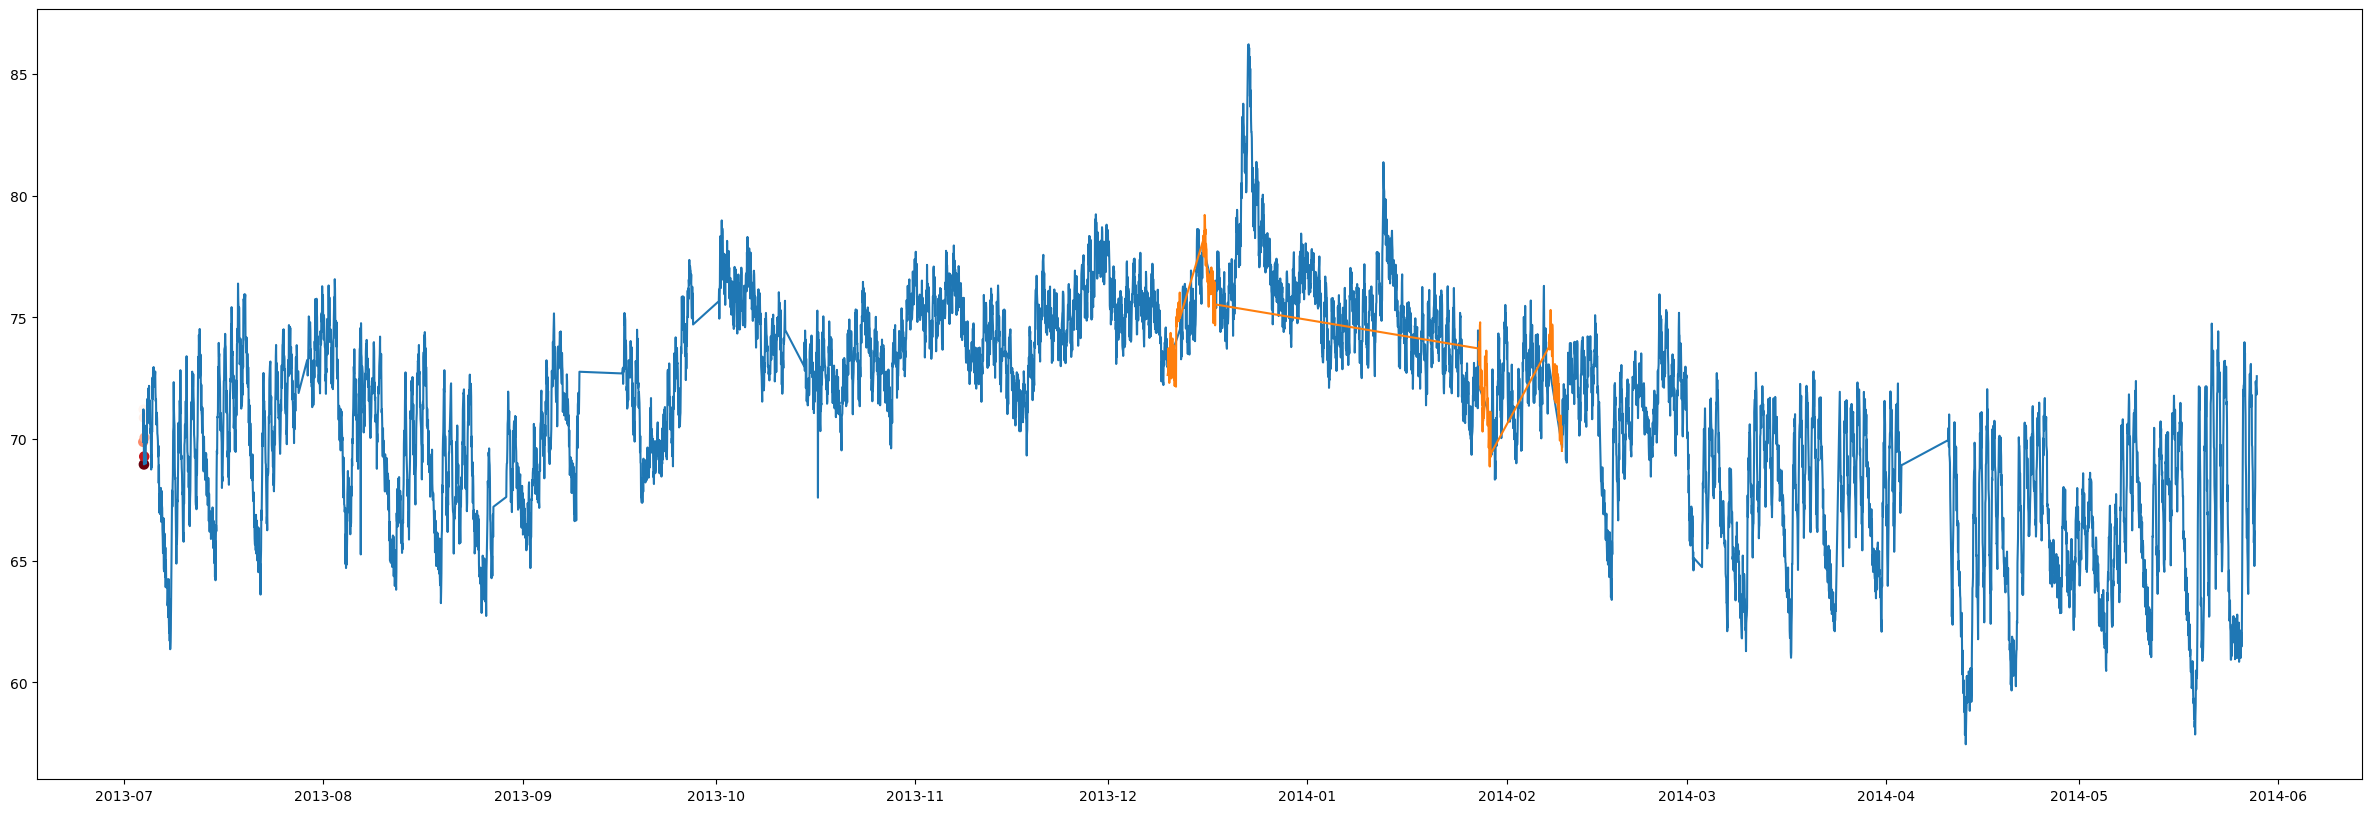

In [79]:
plt.figure(figsize=(30, 10))

plt.plot(normal_data.index, normal_data["value"])
plt.plot(anomalous_data.index, anomalous_data["value"])
plt.scatter(input.index, input['value'], s=input['score']*20, c=input['score'], cmap='Reds')
           

# input to inference

In [52]:
machine_data_numpy = df.value.to_numpy().reshape(-1, 1)

In [54]:
machine_data_numpy[:6]

array([[69.88083514],
       [71.22022706],
       [70.87780496],
       [68.95939994],
       [69.28355102],
       [70.06096581]])

In [56]:
input = df[:6]

# scores from previous inference

In [51]:
scores = {'scores': [{'score': 1.9994143287},
  {'score': 1.8520433754},
  {'score': 1.8688213363},
  {'score': 2.2166723051},
  {'score': 2.1338577115},
  {'score': 1.9616374743}]}

In [70]:
input['score'] = [d['score'] for d in scores['scores']]

/tmp/ipykernel_7629/3370476343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input['score'] = [d['score'] for d in scores['scores']]


In [71]:
input

,value,year,month,day,hour,minute,anomaly,score
timestamp,,,,,,,,
2013-07-04 00:00:00,69.880835,2013,7,4,0,0,0,1.999414
2013-07-04 01:00:00,71.220227,2013,7,4,1,0,0,1.852043
2013-07-04 02:00:00,70.877805,2013,7,4,2,0,0,1.868821
2013-07-04 03:00:00,68.959400,2013,7,4,3,0,0,2.216672
2013-07-04 04:00:00,69.283551,2013,7,4,4,0,0,2.133858
2013-07-04 05:00:00,70.060966,2013,7,4,5,0,0,1.961637


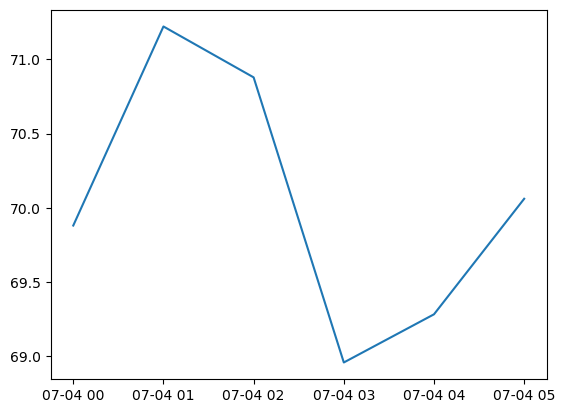

In [73]:
plt.plot(input.index, input["value"])

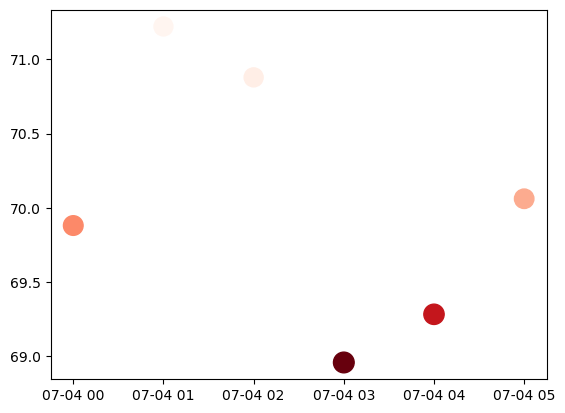

In [77]:
plt.scatter(input.index, input['value'], s=input['score']*100, c=input['score'], cmap='Reds')

In [26]:
# !conda install -y holoviews

In [18]:
import seaborn as sns
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'holoviews'

In [22]:
from sagemaker import RandomCutForest

In [23]:
s3_bucket, prefix

NameError: name 'prefix' is not defined

In [35]:
prefix='randomcut'
rcf = RandomCutForest(role=sm_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location=f's3://{s3_bucket}/{prefix}/',
                      output_path=f's3://{s3_bucket}/{prefix}/output')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [48]:
import numpy as np

In [50]:
multi = np.array([[65,  0, 46],
[22, 95, 16],
[73, 16, 90],
[44, 55, 80]])

In [51]:
multi.shape

(4, 3)

In [52]:
multi.reshape(-1,1)

array([[65],
       [ 0],
       [46],
       [22],
       [95],
       [16],
       [73],
       [16],
       [90],
       [44],
       [55],
       [80]])

In [53]:
multi.reshape(-1,1).shape

(12, 1)

In [42]:
df['value'].to_numpy().shape

(7267,)

In [40]:
df['value'].to_numpy()

array([69.88083514, 71.22022706, 70.87780496, ..., 72.04656545,
       71.82522648, 72.58408858])

In [43]:
df['value'].to_numpy().reshape(-1,1).shape

(7267, 1)

In [38]:
df['value'].to_numpy().reshape(-1,1)

array([[69.88083514],
       [71.22022706],
       [70.87780496],
       ...,
       [72.04656545],
       [71.82522648],
       [72.58408858]])

In [37]:
rcf.record_set(df['value'].to_numpy().reshape(-1,1))

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-1-287758680514/randomcut/RandomCutForest-2024-01-05-01-03-44-149/.amazon.manifest', 'feature_dim': 1, 'num_records': 7267, 's3_data_type': 'ManifestFile', 'channel': 'train'})

In [33]:
rcf.fit(rcf.record_set(df['value'].to_numpy().reshape(-1,1)))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2023-12-08-05-33-50-347


2023-12-08 05:33:50 Starting - Starting the training job......
2023-12-08 05:34:26 Starting - Preparing the instances for training......
2023-12-08 05:35:51 Downloading - Downloading input data...
2023-12-08 05:36:21 Training - Downloading the training image..................
2023-12-08 05:39:07 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[12/08/2023 05:39:31 INFO 139853672802112] Reading default conf

In [54]:
# rcf_interference = rcf.deploy(initial_instance_count=1, ins)


In [36]:
from sagemaker.serverless import ServerlessInferenceConfig

In [37]:
serverless_config = ServerlessInferenceConfig(
    memory_size_in_mb=2048,
    max_concurrency=5
)

In [38]:
rcf.deploy(initial_instance_count=1, serverless_inference_config=serverless_config)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2023-12-08-05-56-39-318
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2023-12-08-05-56-39-318
INFO:sagemaker:Creating endpoint with name randomcutforest-2023-12-08-05-56-39-318


-----!

In [27]:
def list_predictors():
    # Initialize an empty list to store the names of predictors
    predictor_names = []

    # Using the paginator to handle the case where there are more predictors than can be returned in a single API call
    paginator = sm_client.get_paginator('list_endpoints')

    # Iterate over the pages of results
    for page in paginator.paginate():
        # Extract the endpoint names from the current page and add them to the list
        for endpoint in page['Endpoints']:
            predictor_names.append(endpoint['EndpointName'])

    return predictor_names

# Call the function and print the list of predictor names
predictor_names = list_predictors()
print(predictor_names)

['randomcutforest-2023-12-08-05-56-39-318']


In [33]:
machine_data_numpy = df.value.to_numpy().reshape(-1, 1)

In [29]:
machine_data_numpy[:6]

array([[69.88083514],
       [71.22022706],
       [70.87780496],
       [68.95939994],
       [69.28355102],
       [70.06096581]])

In [37]:
from sagemaker.predictor import Predictor

In [38]:
predictor = Predictor(endpoint_name='randomcutforest-2023-12-08-05-56-39-318')

In [39]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()
machine_data_numpy = df.value.to_numpy().reshape(-1, 1)

results = predictor.predict(
    machine_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

In [40]:
results

{'scores': [{'score': 1.9994143287},
  {'score': 1.8520433754},
  {'score': 1.8688213363},
  {'score': 2.2166723051},
  {'score': 2.1338577115},
  {'score': 1.9616374743}]}

## plotting predictions

In [53]:
# scores = []
# for sc in results['scores']:
#     print (sc['score'])
#     scores.add(sc['score'])
    
scores = [item['score'] for item in results['scores']]
print (scores)

[1.9994143287, 1.8520433754, 1.8688213363, 2.2166723051, 2.1338577115, 1.9616374743]


In [5]:
plt.figure(figsize=(12, 6))

# Plotting the data points
plt.subplot(2, 1, 1)  # This allows for a multi-plot of data and scores
plt.plot(machine_data_numpy[:6], 'b-', label='Data Points')
plt.title('Data Points and Anomaly Scores from Random Cut Forest')
plt.ylabel('Data Points')
plt.legend()

# Plotting the anomaly scores
plt.subplot(2, 1, 2)
plt.plot(scores, 'r-', label='Anomaly Scores')
plt.ylabel('Anomaly Score')
plt.xlabel('Data Point Index')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## prediction using invoke_endpoint not working

In [29]:
# Initialize the SageMaker Runtime client
sagemaker_runtime = boto3.client('sagemaker-runtime')

In [30]:
# Example data to be predicted
data = {"features": [5.1, 3.5, 1.4, 0.2]}
serialized_data = json.dumps(machine_data_numpy[:6].tolist())

In [39]:

# Invoke the endpoint
response = sagemaker_runtime.invoke_endpoint(
    EndpointName='randomcutforest-2023-12-08-05-56-39-318',
    ContentType='text/csv',
    Accept= 'application/json',
    Body=serialized_data
)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "unable to evaluate payload provided". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/randomcutforest-2023-12-08-05-56-39-318 in account 287758680514 for more information.

In [32]:
serialized_data

'[[69.88083514], [71.22022706], [70.87780496], [68.95939994], [69.28355102], [70.06096581]]'

In [35]:
json.dumps(machine_data_numpy[:6])

TypeError: Object of type ndarray is not JSON serializable

In [38]:
df['value']

timestamp
2013-07-04 00:00:00    69.880835
2013-07-04 01:00:00    71.220227
2013-07-04 02:00:00    70.877805
2013-07-04 03:00:00    68.959400
2013-07-04 04:00:00    69.283551
                         ...    
2014-05-28 11:00:00    72.370206
2014-05-28 12:00:00    72.172956
2014-05-28 13:00:00    72.046565
2014-05-28 14:00:00    71.825226
2014-05-28 15:00:00    72.584089
Name: value, Length: 7267, dtype: float64

In [51]:
region=boto3.Session().region_name

downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"
data_filename = "NAB_nyc_taxi.csv"
downloaded_data_bucket = f"sagemaker-example-files-prod-{region}"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")


'sagemaker-example-files-prod-us-east-1'

In [52]:
taxi_data

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [53]:
taxi_data.values[:, 1]

array([10844, 8127, 6210, ..., 27309, 26591, 26288], dtype=object)

In [57]:
import numpy as np
def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data

In [58]:
shingle_size = 48

taxi_data_shingled = shingle(taxi_data.values[:, 1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


In [59]:
taxi_data_shingled.shape

(10272, 48)